# Siamese Network with MNIST (small) data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
import glob
from torchviz import *

In [2]:
POS_LABEL = 0 # Pair of Images that match
NEG_LABEL = 1 #Pair of Images that do not match
#If you reverse the labels, you have to change the Contrastive Loss function.
SZ = 28
MARGIN = 5.0

## Model

In [3]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*SZ*SZ, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def feature_extract(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)        
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.feature_extract(input1) #extract features from image0
        output2 = self.feature_extract(input2) #extract features from image1
        return output1, output2
    
    
net = SiameseNetwork()
print(net)

X0 = torch.zeros((2,1, SZ, SZ)) #channel first (after batch)
X1 = torch.zeros((2,1, SZ, SZ)) #channel first (after batch)
d1,d2 = net(X0,X1)

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=6272, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)


## Contrastive Loss function

In [4]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=MARGIN):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        pred = (self.margin < euclidean_distance).type(torch.float)         
        return loss_contrastive, euclidean_distance, pred

## BCELoss (did not do well)

In [5]:
#did not work well, you can try by setting criterion = SimpleBCELoss() below.
class SimpleBCELoss(torch.nn.Module):
    
    def __init__(self):
        super(SimpleBCELoss,self).__init__()
        self.bce_loss = nn.BCELoss()
            
    def forward(self,output1,output2,label):
        edist = nn.PairwiseDistance(p=2,keepdim=True)(output1,output2)
        edist = torch.sigmoid(edist)
        loss_bce = self.bce_loss(edist,label)
        return loss_bce

## Make paired data

In [6]:
def get_positive_pairs(path='./data/mnist_small/*'): #both images of same digit
    positive_pairs = []
    all_fam_dirs = glob.glob(path)
    for famdir in all_fam_dirs:
        mol_files = glob.glob(famdir+'/*.png')
        for ff1 in mol_files:
            for ff2 in mol_files:
                if ff1 < ff2:
                    positive_pairs.append((ff1,ff2))
    return positive_pairs


def get_negative_pairs(path='./data/mnist_small/*',cnt=100): #images are from different digits
    negative_pairs = []
    all_fam_dirs = glob.glob(path)
    random.shuffle(all_fam_dirs)
    all_fam_dirs_rev = all_fam_dirs[::-1] #reversed
    for famdir1,famdir2 in zip(all_fam_dirs,all_fam_dirs_rev):
        if famdir1!=famdir2:
            mol_files_1 = glob.glob(famdir1+'/*.png')
            mol_files_2 = glob.glob(famdir2+'/*.png')
            for ff1 in mol_files_1:
                for ff2 in mol_files_2:
                    negative_pairs.append((ff1,ff2))
        if len(negative_pairs) >= cnt:
            break
            
    return negative_pairs


def read_img(img_path):
    img = Image.open(img_path)
    img = img.convert('L')
    img = np.asarray(img,dtype=np.float32)/255.0
    return img

def build_paired_data(path,shuffle):
    positive_pairs = get_positive_pairs(path) 
    negative_pairs = get_negative_pairs(path,len(positive_pairs))
    
    print('Got ',len(positive_pairs),'positive_pairs')
    print('Got ',len(negative_pairs),'negative_pairs')
    
    if shuffle:
        random.shuffle(positive_pairs)
        random.shuffle(negative_pairs)
        
    positive_labels = [POS_LABEL]*len(positive_pairs)
    negative_labels = [NEG_LABEL]*len(negative_pairs)

    all_pairs = positive_pairs + negative_pairs
    all_labels = positive_labels + negative_labels
 
    data = list(zip(all_pairs,all_labels))
    random.shuffle(data)
    print('Loading data size',len(data))
    
    pairImages = []
    pairLabels = []
    pairNames = []

    for image_pair,label in data:
        img0 = read_img(image_pair[0])
        img1 = read_img(image_pair[1])
        
        pairImages.append([img0,img1])
        pairLabels.append([label]) #very important to have labels as shape `batch_size` x 1   
        pairNames.append([image_pair[0],image_pair[1]])
        
    return np.expand_dims(np.array(pairImages),axis=2), np.array(pairLabels), np.array(pairNames)

In [7]:
pairTrain, labelTrain, pairNames = build_paired_data('./data/mnist_small/*',True)
print(pairTrain.shape, labelTrain.shape)

Got  12250 positive_pairs
Got  12500 negative_pairs
Loading data size 24750
(24750, 2, 1, 28, 28) (24750, 1)


## Create Siamese network and train

In [8]:
new_net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(new_net.parameters(),lr = 0.0005)

num_epochs = 10
batch_size = 64

num_batches = len(pairTrain) // batch_size

counter = []
loss_history = [] 
itr_no = 0

for epoch in range(num_epochs):
    epoch_loss = []  # Sum of training loss, no. of tokens
    epoch_accuracy = []
    
    for batch_no in range(num_batches):

        optimizer.zero_grad()

        # Local batches and labels
        X =  pairTrain[batch_no*batch_size:(batch_no+1)*batch_size,]
        y = labelTrain[batch_no*batch_size:(batch_no+1)*batch_size,]

        X0 = torch.tensor(X[:, 0]).float().cuda()
        X1 = torch.tensor(X[:, 1]).float().cuda()
        Y = torch.tensor(y).float().cuda()
        
        output1,output2 = new_net(X0,X1)
        loss_contrastive, edist, predictions = criterion(output1,output2,Y)
        loss_contrastive.backward()
        optimizer.step()

        epoch_loss.append(loss_contrastive.item())
        acc = (Y==predictions).type(torch.float).cpu().numpy()
        epoch_accuracy.extend(acc)

    epoch_loss = np.mean(epoch_loss)
    print('epoch',epoch,'loss=',epoch_loss,'acc=',np.mean(epoch_accuracy))
    loss_history.append(epoch_loss)
    counter.append(epoch)

epoch 0 loss= 0.27836854458144755 acc= 0.9397668
epoch 1 loss= 0.006685544429660577 acc= 0.97862697
epoch 2 loss= 0.0030493547025841174 acc= 0.98680377
epoch 3 loss= 0.0027966836424860525 acc= 0.98801816
epoch 4 loss= 0.0016000263142300567 acc= 0.9904874
epoch 5 loss= 0.0016307994742772826 acc= 0.99032545
epoch 6 loss= 0.00105960816565667 acc= 0.9937257
epoch 7 loss= 0.000999336756347833 acc= 0.99271375
epoch 8 loss= 0.025550793732276398 acc= 0.98482025
epoch 9 loss= 0.00034351828647377825 acc= 0.99740934


## Plot training loss

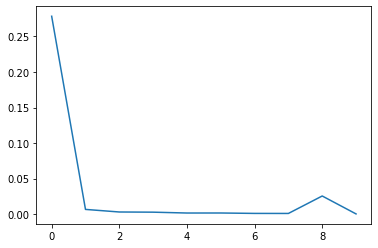

In [9]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    
show_plot(counter,loss_history)

## Visualize dynamic graph

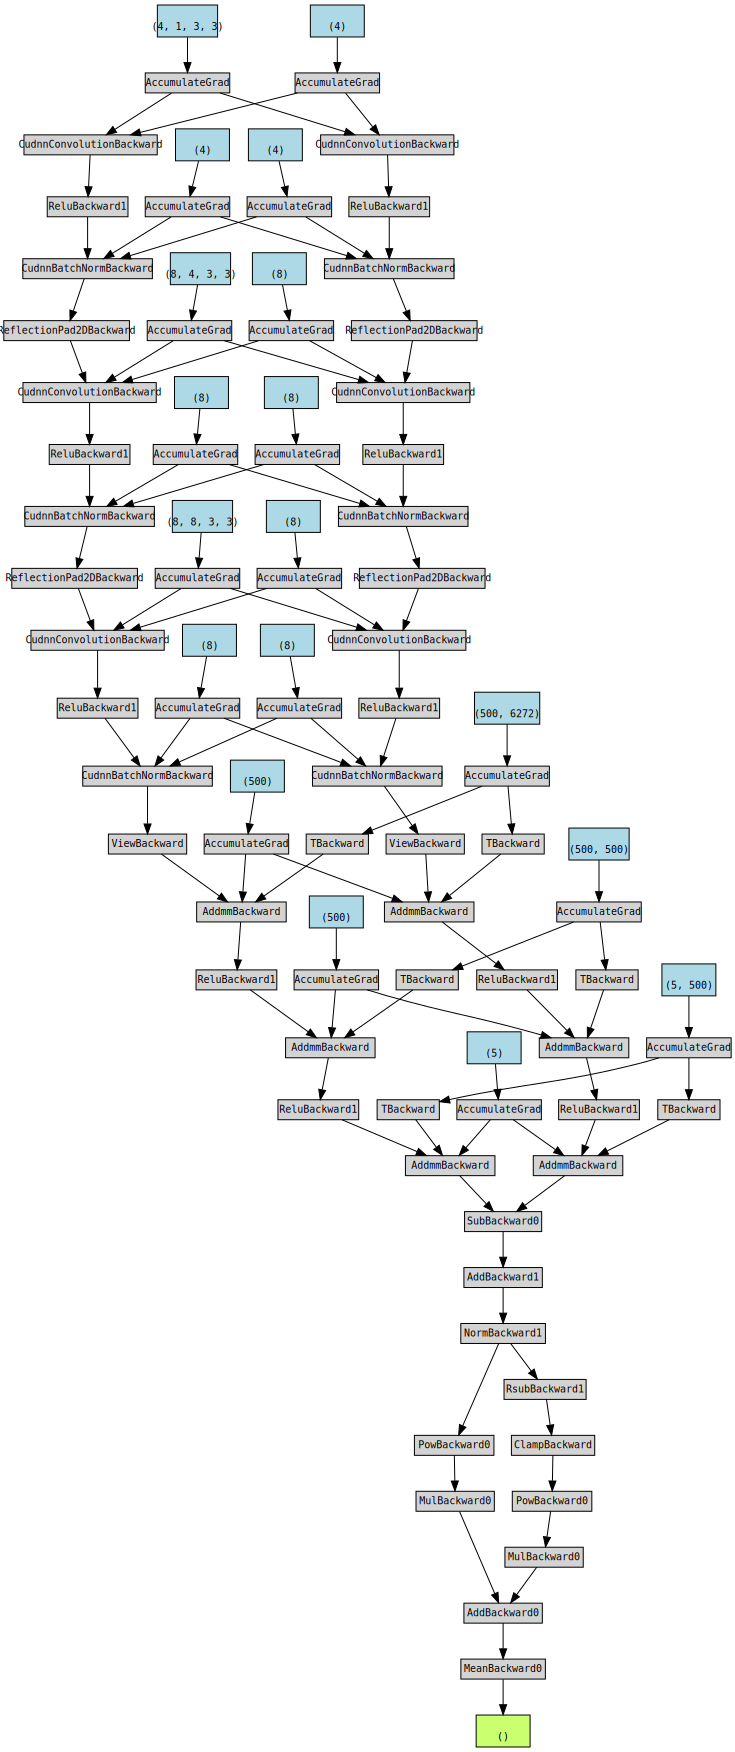

In [10]:
make_dot(loss_contrastive)

## Plot some images and their predictions

In [11]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(60, 5, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

In [12]:
X =  pairTrain[100:110,]
y = labelTrain[100:110,]

X0 = torch.tensor(X[:, 0]).float().cuda()
X1 = torch.tensor(X[:, 1]).float().cuda()
Y = torch.tensor(y).float().cuda()
        
output1,output2 = new_net(X0,X1)
loss_contrastive, edist, predictions = criterion(output1,output2,Y)
#edist = F.pairwise_distance(output1, output2, keepdim = True)

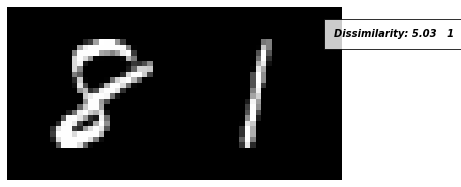

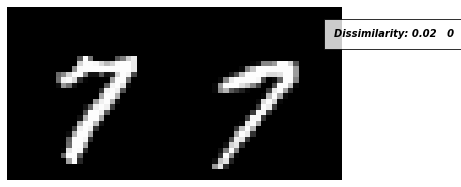

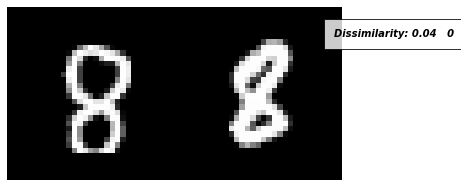

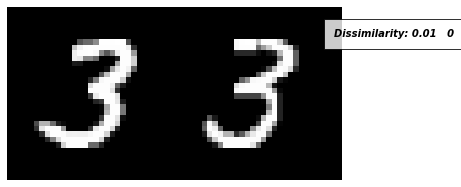

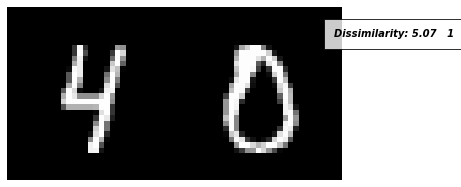

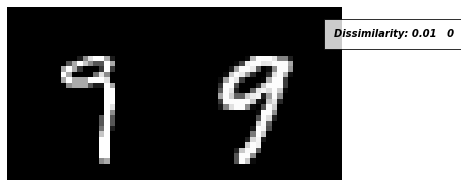

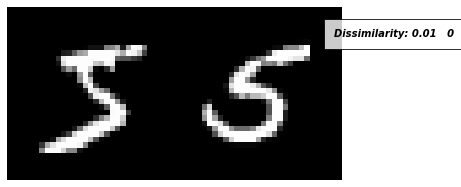

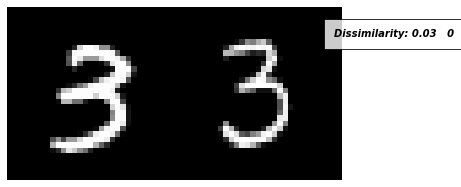

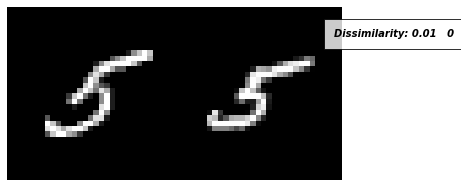

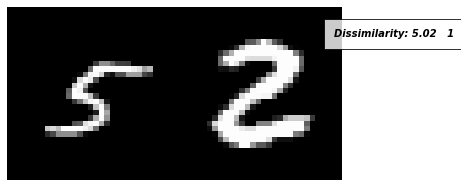

In [13]:
for i in range(10):
    z = torch.cat((X0[i:i+1],X1[i:i+1]),0).cpu()
    d = edist[i].cpu().item()
    pred = int(predictions[i].cpu().item())
    imshow(torchvision.utils.make_grid(z),'Dissimilarity: {:.2f}   {}'.format(d,pred))